In [1]:
import pandas as pd
import docx
import re
import numpy as np
import seaborn as sns
import os
import deeppavlov

from tqdm import tqdm
from ftfy import fix_text
from glob import glob
from pymystem3 import Mystem
from openpyxl import load_workbook
from transformers import BertTokenizer
from nltk.corpus import stopwords
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from scipy import spatial
from tika import parser
from string import punctuation

from deeppavlov.models.tokenizers.ru_sent_tokenizer import RuSentTokenizer as SentTokenizer
from deeppavlov.models.tokenizers.ru_tokenizer import RussianTokenizer as Tokenizer

#import seaborn as sns
#import matplotlib.pyplot as plt
#import win32com.client as win32
#from win32com.client import constants

#%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /home/nanosemantics/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nanosemantics/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/nanosemantics/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/nanosemantics/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!


## Подготовка файла ППР

In [156]:
paths = glob(r'./data/*ППР*.docx', recursive=True)
paths

['./data/1000-11-ППР-УПНГ.docx']

In [128]:
def read_docx(path):
    doc_texts = []
    doc = docx.Document(path)
    text = '\n'.join([doc.paragraphs[i].text for i in range(len(doc.paragraphs))])
    splt_texs = [re.sub(r'\s+', ' ', sentence) for sentence in text.split('\n') if sentence and sentence != ' ']
    doc_texts.extend(splt_texs)
    return doc_texts

In [129]:
russian_stopwords = stopwords.words("russian")

class Stemmer(object):
    def __init__(self):
        self.mystem = Mystem()
        
    #Preprocess function
    def preprocess_text(self, text):
        norm_tokens = self.mystem.lemmatize(text)
        norm_tokens = [token.strip('\n') for token in norm_tokens if token not in russian_stopwords and token != " " and token.strip() not in punc]
        text = " ".join(norm_tokens)
        return text

In [130]:
doc_ppr = read_docx(paths[0])
df = pd.DataFrame(doc_ppr, columns=['sent'])
df['len'] = df['sent'].apply(lambda x: len(x))

drop_ind = df[(df['sent'].apply(lambda x: '1000/' in x) & df['len'].apply(lambda x: x <= 20)) | df['len'].apply(lambda x: x < 17)].index
df.drop(drop_ind, axis=0, inplace=True)

df.drop_duplicates(inplace=True)

punc = punctuation
punc += '«»―'

stemmer = Stemmer()
df['lemmatize_sent'] = df['sent'].apply(lambda text: stemmer.preprocess_text(text))

doc_ppr_raw = df['sent'].values
doc_ppr = df['lemmatize_sent'].values

In [131]:
doc_ppr[:10]

array(['проект производство работа',
       'обустройство тазовский месторождение',
       'установка подготовка нефть газ',
       'разрабатывать инженер отдел идипс ао премьерстрой глебов д',
       'г тюмень 2019г', 'l общий положение',
       'настоящий проект производство работа распространяться организация безопасный производство контроль приемка основной работа строительство объект : « обустройство тазовский месторождение установка подготовка нефть газ',
       'административный отношение объект строительство : « обустройство тазовский месторождение установка подготовка нефть газ располагать территория тазовский район ямало-ненецкий автономный округ тюменский область 8 км юго-восток поселок газ сало',
       'близкий населенный пункт район строительство являться поселок газ сало также поселок тазовский',
       'настоящий ППР разрабатывать ао премьерстрой основание договор № ГНР 19 11023 00070 р 15 выполнение строительно-монтажный работа'],
      dtype=object)

In [132]:
sent_tokenizer = SentTokenizer()
tokenizer = Tokenizer(stopwords=stopwords.words('russian'), alphas_only=False)
#bert_tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence', do_lower_case=True, do_basic_tokenize=False)

## Подготовка файла ПОС

In [133]:
def read_pdf(path):
    data = parser.from_file(path)
    data = ' '.join(re.sub(r'\n+', '\n', data['content']).split('\n'))
    return re.sub('\s+', ' ', data)

In [134]:
pdf_paths = glob(r'./data/*Раздел*.pdf', recursive=True)
pdf_paths

['./data/Раздел ПД N6 ПОС-1 (1000-11-П-ПОС, 2020).pdf',
 './data/Раздел ПД N6 ПОС УПНГ (1000-11-П-ПОС, 2019).pdf']

In [135]:
doc_pos = sent_tokenizer([read_pdf(pdf_paths[1])])[0]
#doc_pos_2 = sent_tokenizer([read_pdf(pdf_paths[1])])

df = pd.DataFrame(doc_pos, columns=['sent'])
df = df[~df['sent'].apply(lambda x: 'Text' in x or 'AutoCad' in x or 'normacs' in x or 'гипровостокнефть' in x.lower())]
df['len'] = df['sent'].apply(lambda x: len(x))

map_ = {ord('\uf0b4'): '',
        ord('\uf02b'): '',
        ord('\uf03d'): '',
        ord('\uf0d7'): '',
        ord('\uf02d'): '',
        ord('\uf0bb'): ''}

df = df[~df['sent'].apply(lambda x: 'Т е к с т о в а я' in x or 'Р а з д е л' in x or 'Ф а й л' in x or 'П о д п и с ь' in x or '1000/11-П-ПОС-ПрилБ_4 1000/11-П-ПОС-ПрилВ_4' in x)]
df['sent'] = df['sent'].apply(lambda x: x.translate(map_))
df.drop_duplicates(inplace=True)
df = df[df['len']> 17]
df['lemmatize_sent'] = df['sent'].apply(lambda text: stemmer.preprocess_text(text))

doc_pos_raw = df['sent'].values
doc_pos = df['lemmatize_sent'].values

In [137]:
doc_pos[:10]

array(['2019 свидетельство № 0002 2012 6315200011 07 7 декабрь 2012 г заказчик  –  ооо газпромнефть ямал обустройство тазовский месторождение',
       'установка подготовка нефть газ проектный документация раздел 6',
       'проект организация строительство 1000 11 п пос 6 изм',
       'дата 4 1788 19 27.03 19 з м',
       'проект организация строительство 1000 11 п пос 6 главный инженер н п попов главный инженер проект н володин з м',
       'кол уч лист № док', 'подпись дата н',
       '4 зам .)  1000 11 п сп состав проектный документация 1000 11 п пос раздел 6',
       'проект организация строительство', 'текстовой часть изм'],
      dtype=object)

## Дополнительный препроцессинг документов

In [144]:
doc_pos = [re.sub(r'[\)\(»«:.,/;•]{1}', '', sent) for sent in doc_pos]
doc_ppr = [re.sub(r'[\)\(»«:.,/;•]{1}', '', sent).strip() for sent in doc_ppr]

doc_pos = [re.sub(r'[_—–]{1}', ' ', sent) for sent in doc_pos]
doc_ppr = [re.sub(r'[_—–]{1}', ' ', sent).strip() for sent in doc_ppr]

doc_pos = [re.sub(r'\s+', ' ', sent) for sent in doc_pos]
doc_ppr = [re.sub(r'\s+', ' ', sent) for sent in doc_ppr]

In [145]:
assert (len(doc_pos) == len(doc_pos_raw)) & (len(doc_ppr) == len(doc_ppr_raw))

In [146]:
doc_ppr = list(doc_ppr)
doc_pos = list(doc_pos)

#tokenized_ppr = [[token.lower() for token in bert_tokenizer.tokenize(sentence)] for sentence in doc_ppr]
#tokenized_pos = [[token.lower() for token in bert_tokenizer.tokenize(sentence)] for sentence in doc_pos]

tokenized_ppr = tokenizer(doc_ppr)
tokenized_pos = tokenizer(doc_pos)

train_tokenized_sents = tokenized_ppr + tokenized_pos
train_sents = doc_ppr + doc_pos
train_sents_raw = list(doc_ppr_raw) + list(doc_pos_raw)

In [147]:
labels = ['ppr' for _ in range(len(list(doc_ppr_raw)))] + ['pos' for _ in range(len(list(doc_pos_raw)))]

train_sents_raw_df = pd.DataFrame(train_sents_raw, columns=['sent'])
train_sents_raw_df['label'] = labels

In [149]:
train_tokenized_sents[:10]

[['проект', 'производство', 'работа'],
 ['обустройство', 'тазовский', 'месторождение'],
 ['установка', 'подготовка', 'нефть', 'газ'],
 ['разрабатывать',
  'инженер',
  'отдел',
  'идипс',
  'ао',
  'премьерстрой',
  'глебов',
  'д'],
 ['г', 'тюмень', '2019г'],
 ['l', 'общий', 'положение'],
 ['настоящий',
  'проект',
  'производство',
  'работа',
  'распространяться',
  'организация',
  'безопасный',
  'производство',
  'контроль',
  'приемка',
  'основной',
  'работа',
  'строительство',
  'объект',
  'обустройство',
  'тазовский',
  'месторождение',
  'установка',
  'подготовка',
  'нефть',
  'газ'],
 ['административный',
  'отношение',
  'объект',
  'строительство',
  'обустройство',
  'тазовский',
  'месторождение',
  'установка',
  'подготовка',
  'нефть',
  'газ',
  'располагать',
  'территория',
  'тазовский',
  'район',
  'ямало-ненецкий',
  'автономный',
  'округ',
  'тюменский',
  'область',
  '8',
  'км',
  'юго-восток',
  'поселок',
  'газ',
  'сало'],
 ['близкий',
  'населе

## Обучение векторизатора Word2Vec для получения векторных представлений слов

In [158]:
VECTOR_SIZE = 200

model = Word2Vec(sentences=train_tokenized_sents, vector_size=VECTOR_SIZE, workers=10, alpha=0.025, epochs=10, min_count=2, max_vocab_size=100000)
model.save("word2vec.model")

### Посмотрим на слова, которые лежат близко в пространстве

In [159]:
model.wv.most_similar('электрический')

[('прокладываться', 0.9974771738052368),
 ('электрообогрев', 0.9960862994194031),
 ('порожний', 0.9948625564575195),
 ('опора', 0.9946585297584534),
 ('штуцер', 0.9946041107177734),
 ('пролагать', 0.994421660900116),
 ('факел', 0.9942864775657654),
 ('химический', 0.9941856861114502),
 ('верхний', 0.9941197037696838),
 ('наполнительный', 0.9940759539604187)]

In [160]:
model.wv.most_similar('рабочий')

[('работник', 0.9664180874824524),
 ('нетрезвый', 0.956488311290741),
 ('время', 0.9547008275985718),
 ('обеденный', 0.9535852670669556),
 ('проходить', 0.9472776651382446),
 ('нахождение', 0.9458402395248413),
 ('зимний', 0.9435594081878662),
 ('иметь', 0.9431988000869751),
 ('инструктаж', 0.9416723847389221),
 ('обратно', 0.939297616481781)]

## Считаем document frequency для использования вместе с term frequency при расчете векторов предложений

In [161]:
token_idf = {}

for sent in train_tokenized_sents:
    for token in set(sent):
        if token in token_idf:
            token_idf[token] += 1
        else:
            token_idf[token] = 1

## Считаем векторные представления предложений, как среднее всех векторов слов умноженных на Tf * Idf

In [162]:
sentence_vectors = np.empty((len(train_tokenized_sents), VECTOR_SIZE))
a, n = 0, 0

for i, tokenized_sent in enumerate(train_tokenized_sents):
    sentence_vector = np.empty((len(tokenized_sent), VECTOR_SIZE))
    
    for j, token in enumerate(tokenized_sent):
        try:
            a += 1
            token_vector = model.wv[token.lower()]
            tf =  tokenized_sent.count(token) / len(tokenized_sent)
            df = token_idf[token]
            tfidf = tf / np.log(df)
            sentence_vector[j] = token_vector * tfidf
        except:
            n += 1
            #sentence_vector[j] = sentence_vector.mean(axis=0)
            pass
    pooled_sentence_vector = sentence_vector.mean(axis=0)
    sentence_vectors[i] = pooled_sentence_vector 
    
print(n)

/home/nanosemantics/sasha/num_seq2seq/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/home/nanosemantics/sasha/num_seq2seq/lib/python3.6/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


2783


In [163]:
print(a)

82910


In [164]:
assert len(train_tokenized_sents) == sentence_vectors.shape[0]

## Ищем наиболее похожие предложения из документа ПОС на предложения документа ППР

In [165]:
def most_similar_sent(input_sentence, voc_vectors):
    tokenized_sentence = tokenizer([input_sentence])[0]
    #tokenized_sentence = bert_tokenizer.tokenize(input_sentence)
    NUM_TOKENS = len(tokenized_sentence)
    #print(NUM_TOKENS)
    input_vector = np.empty((NUM_TOKENS, VECTOR_SIZE))
    n = 0
    for i, token in enumerate(tokenized_sentence):
        try:
            token_vector = model.wv[token]
            #print(token)
            tf =  tokenized_sentence.count(token) / len(tokenized_sentence)
            df = token_idf[token]
            
            tfidf = tf / np.log(df)
            input_vector[i] = token_vector * tfidf
        except:
            pass
            n += 1
            #input_vector[i] = input_vector.mean(axis=0)
        
    #print('% null tokens: ', n / NUM_TOKENS)
    input_vector = input_vector.mean(axis=0)
    distances = {}
    
    for i, voc_vector in enumerate(voc_vectors):
        dist = spatial.distance.cosine(input_vector, voc_vector)
        #print(dist)
        distances[i] = dist
    return distances

In [166]:
similar_sents_to_pos = {}

for i, pos_sent in tqdm(enumerate(doc_pos)):
    distances = most_similar_sent(pos_sent, sentence_vectors)

    for ind, dist in sorted(distances.items(), key=lambda x: x[1], reverse=False)[:10]:
        if train_sents_raw_df.iloc[ind, 1] == 'ppr':
            multi_ind = str(i) + '_' + str(ind)
            similar_sents_to_pos[multi_ind] = {
                'pos_sent': doc_pos_raw[i], 
                'distance': dist, 
                'find_text': train_sents_raw_df.iloc[ind, 0], 
                'label': train_sents_raw_df.iloc[ind, 1]
            }

0it [00:00, ?it/s]/home/nanosemantics/sasha/num_seq2seq/lib/python3.6/site-packages/scipy/spatial/distance.py:719: RuntimeWarning: overflow encountered in square
  vv = np.average(np.square(v), weights=w)
317it [01:47,  3.44it/s]/home/nanosemantics/sasha/num_seq2seq/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/home/nanosemantics/sasha/num_seq2seq/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
2026it [10:58,  3.51it/s]/home/nanosemantics/sasha/num_seq2seq/lib/python3.6/site-packages/scipy/spatial/distance.py:718: RuntimeWarning: overflow encountered in square
  uu = np.average(np.square(u), weights=w)
/home/nanosemantics/sasha/num_seq2seq/lib/python3.6/site-packages/scipy/spatial/distance.py:717: RuntimeWarning: overflow encountered in multiply
  uv = np.average(u * v, 

## Получаем таблицу с данными следующего формата:

pos_sent - предложение из документа ПОС</br>
distance - косинусное расстояние между объектами (чем меньше, тем более предложения похожи друг на друга)</br>
find_text - сопоставленное предложение из документа ППР

In [167]:
sim_sents = pd.DataFrame.from_dict(similar_sents_to_pos, orient='index', columns=['pos_sent', 'distance', 'find_text'])
sim_sents.dropna(inplace=True)

In [177]:
sim_sents = sim_sents.sort_values(by=['pos_sent', 'distance']).drop_duplicates(['pos_sent']).sort_values(by='distance')

In [179]:
sim_sents

,pos_sent,distance,find_text
1151_681,Непосредственно перед выполнением разбивочных ...,0.000000,Непосредственно перед выполнением разбивочных ...
1809_1046,При прокладке каждая кабельная линия маркирует...,0.000000,При прокладке каждая кабельная линия маркирует...
1806_1044,Работы по установке опорных конструкций для мо...,0.000000,Работы по установке опорных конструкций для мо...
1396_853,При монтаже конструкций должно осуществляться ...,0.000000,При монтаже конструкций должно осуществляться ...
1394_851,Для перевозки конструкций используется автотра...,0.000000,Для перевозки конструкций используется автотра...
...,...,...,...
1671_136,Текстовая часть Опорожнение резервуара.,0.137068,6.1. Площадка слива;
1740_1,Текстовая часть сверху с заделкой ее в верхней...,0.142056,«Обустройство Тазовского месторождения.
2739_1,Текстовая часть 26.,0.143364,«Обустройство Тазовского месторождения.
9_1,Текстовая часть Изм.,0.144354,«Обустройство Тазовского месторождения.


In [178]:
sim_sents.to_excel('sim_sents_3.xlsx', index=False, encoding='utf-8')

In [85]:
sim_sents.sort_values(by='distance').head(50)

,pos_sent,distance,find_text,label
242_2,Установка подготовки нефти и газа».,0.00000,Установка подготовки нефти и газа.»,ppr
540_290,Блок электродегидраторов (ЭГ-1-1...3).,0.00000,- Блок электродегидраторов (ЭГ-1-1...3);,ppr
545_291,"Блок дренажных емкостей (ДЕ-2-1,2).",0.00000,"- Блок дренажных емкостей (ДЕ-2-1,2);",ppr
551_293,Блок факельного сепаратора Сф-1.,0.00000,- Блок факельного сепаратора Сф-1;,ppr
1729_245,"Растительность по трассе – кустарнички, тундро...",0.00000,"Растительность по трассе – кустарнички, тундро...",ppr
542_312,Оппозитно расположены два опциональных модуля ...,0.00007,- Азотно-воздушная станция с ресиверами (Рв-2-...,ppr


/home/nanosemantics/sasha/num_seq2seq/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='distance', ylabel='Density'>

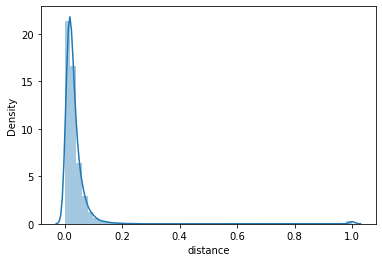

In [102]:
sns.distplot(sim_sents['distance'])

In [131]:
sim_sents['distance'].describe()

count    7782.000000
mean        0.000076
std         0.000016
min         0.000000
25%         0.000065
50%         0.000078
75%         0.000089
max         0.000100
Name: distance, dtype: float64

In [137]:
sim_sents[sim_sents.distance < 0.00005].tail(5).values

array([['Программа комплексной наладки узлов предусматривает на первой стадии раздельную работу специалистов различных профессий для первоначальной наладки отдельных видов оборудования с целью обеспечения надежности установки в проектном объеме, а затем - комплексную работу узловых бригад, создаваемых на этапе приемки, под техническим руководством бригадиров.',
        4.152538522583793e-05,
        'Поставка блоков с предприятий-изготовителей, сборочно-комплектовочных предприятий и баз к месту их установки, должна производиться в строгой технологической последовательности возведения объектов, предусмотренных графиком производства работ.',
        'ppr'],
       ['Программа комплексной наладки узлов предусматривает на первой стадии раздельную работу специалистов различных профессий для первоначальной наладки отдельных видов оборудования с целью обеспечения надежности установки в проектном объеме, а затем - комплексную работу узловых бригад, создаваемых на этапе приемки, под техническим

In [67]:
input_text = """при производстве сварочных работ в условиях отрицательных температурах
окружающего воздуха необходим подогрев кромок на 100 - 150 °С. Сварочные работы в
зимний период выполняются с устройством укрытий (типа палатки), защищающих сварщика
и место проведения работ от атмосферных осадков и ветра"""

ind_inp = 2240
input_text = doc_pos[ind_inp]
input_text = stemmer.preprocess_text(input_text)

input_text = re.sub(r'[\)\(»«:.,/;•]{1}', '', input_text)
input_text = re.sub(r'[-_—]{1}', ' ', input_text)
input_text = re.sub(r'\s+', ' ', input_text)
input_text

distances = most_similar_sent(input_text, sentence_vectors)
print()
#print('Input_text:', doc_pos_raw[ind_inp])
print('Input_text:', input_text)
print()

for ind, dist in sorted(distances.items(), key=lambda x: x[1], reverse=False)[:10]:
    if train_sents_raw_df.iloc[ind, 1] == 'ppr' and dist < 1e-4:
        print('Dist:', dist, '| find text: ', train_sents_raw_df.iloc[ind, 0], '| label: ', train_sents_raw_df.iloc[ind, 1])
        print()

BrokenPipeError: [Errno 32] Broken pipe

In [62]:
sorted(distances.items(), key=lambda x: x[1], reverse=True)[:10]

[(7, 1.0),
 (30, 1.0),
 (62, 1.0),
 (248, 1.0),
 (273, 0.3180182373278404),
 (287, 0.3137614001264736),
 (152, 0.31080402439309984),
 (2622, 0.30552693923793095),
 (116, 0.29971639300159225),
 (2668, 0.2990710798831687)]

In [406]:
print(input_text)

Для строительства предполагается использовать мобильные здания типа «Ермак» (здания «Ермак 600», длина 6,1м, ширина 2,5 м и «Ермак-800», длина 8 м, ширина 2,8 м).


In [74]:
input_text

'Для всех технологических трубопроводов, за исключением трубопроводов сброса на свечу рассеивания, максимальное рабочее давление принято равным расчетному давлению.'

In [41]:
import torch
import torch.nn as nn

In [46]:
nn.Softmax

torch.nn.modules.activation.Softmax

In [47]:
import torch
import torch.nn as nn

class DocModelForMaskedLM(nn.Module):
    def __init__(self):
        super(self, DocModelForMaskedLM).__init__()
        config = BertConfig.from_pretrained('DeepPavlov/rubert-base-cased-sentence')
        self.bert_model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence', config=config)
        self.dense_layer = nn.Linear(config.hidden_size, self.hidden_neurons)
        self.out_layer = nn.Linear(self.hidden_neurons, config.vocab_size)
        self.dropout = nn.Dropout()
        self.activation = nn.Softmax(dim=1)
    
    def forward(self, inputs, labels):
        seq_output = bert_model(**inputs, labels=labels)
        pooled_output = self.dropout(seq_output.mean(axis=0))
        output = self.out_layer(self.dense_layer(pooled_output))
        output = self.dropout(output)
        return self.activation(output)

In [ ]:
table = pd.read_csv('./data/table_3.csv')
table_cols = table.isnull().sum() == table.isnull().sum().max()
not_null_cols = table_cols[table_cols == False].index
table[not_null_cols]

In [ ]:
import camelot

table = camelot.read_pdf('pdf_paths[1]')